In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/ssac19/aiffel/kaggle_kakr_housing/data/train.csv
/home/ssac19/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
#데이터를 각각 data,sub로 불러온다.
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
#y에 가격정보 칼럼을 할당하고, 데이터에서 가격칼럼 지우기.
y = data['price']

del data['price']

In [6]:
train_len = len(data) # train 데이터 크기를 저장해서 합쳐진 데이터에서 학습 데이터만 따로 빼올 수 있도록 하가.
data = pd.concat((data, sub), axis=0) # data가 train용, sub가 test용

In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

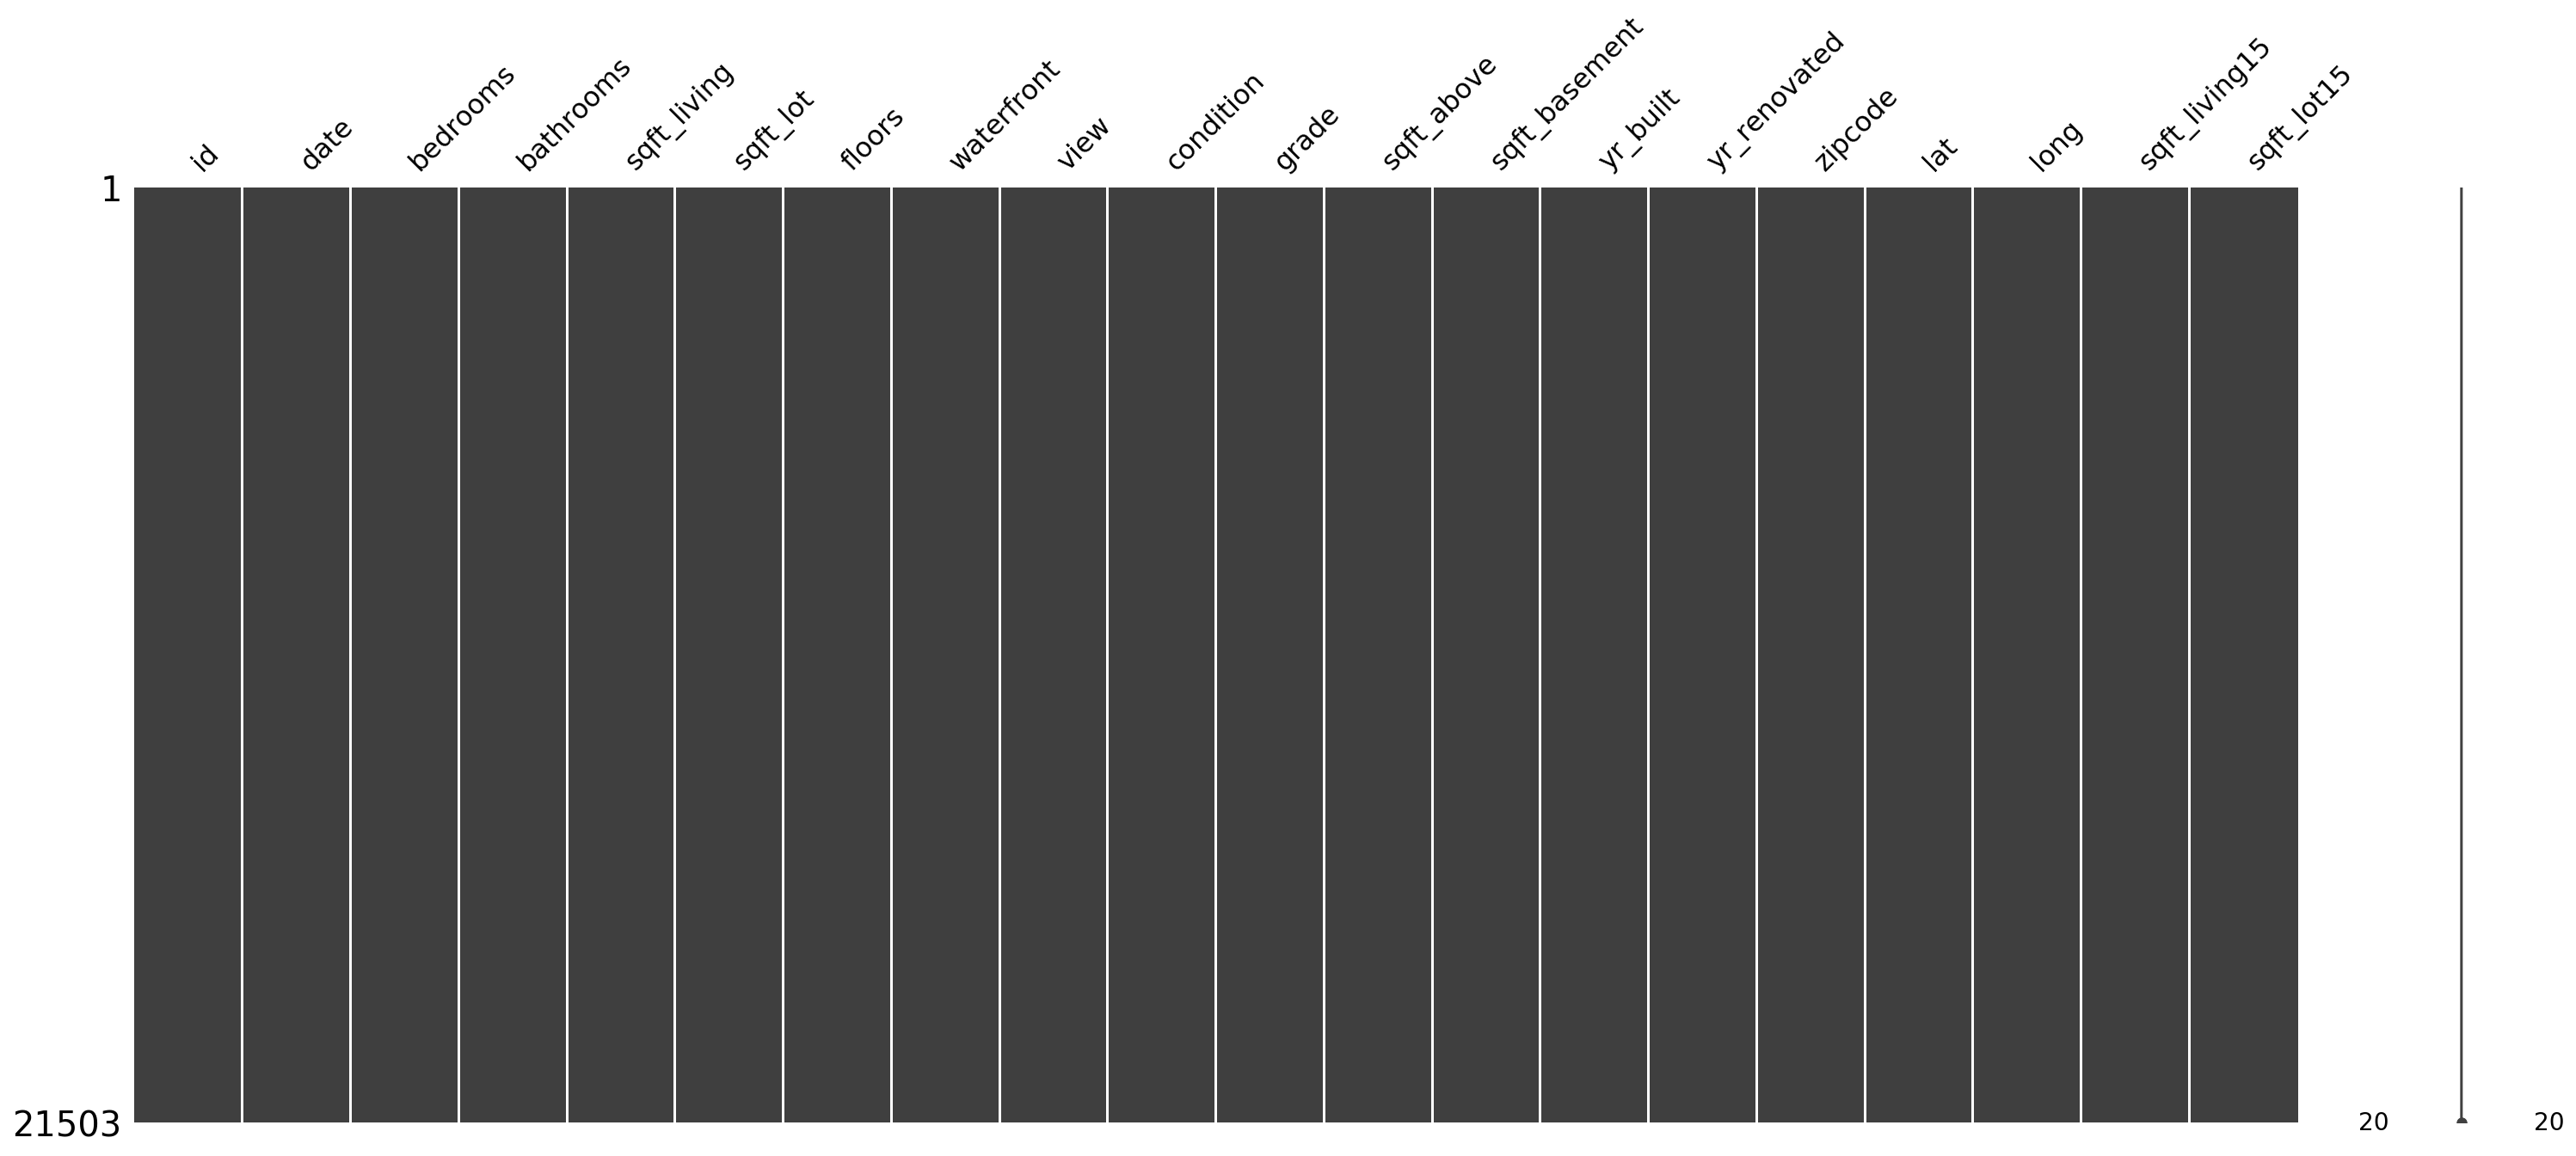

In [8]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다. 결측치가 있으면 해당부분이 하얗게 나옵니다.<br>

In [9]:
for c in data.columns: #각 칼럼마다 결측치가 있는지 확인하는 코드
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [10]:
sub_id = data['id'][train_len:]#테스트용 데이터의 아이디 값들을 따로 저장.
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str) 
# 날짜 칼럼의 데이터를 앞에서부터 6글자까지만 자르기.(년도,월)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

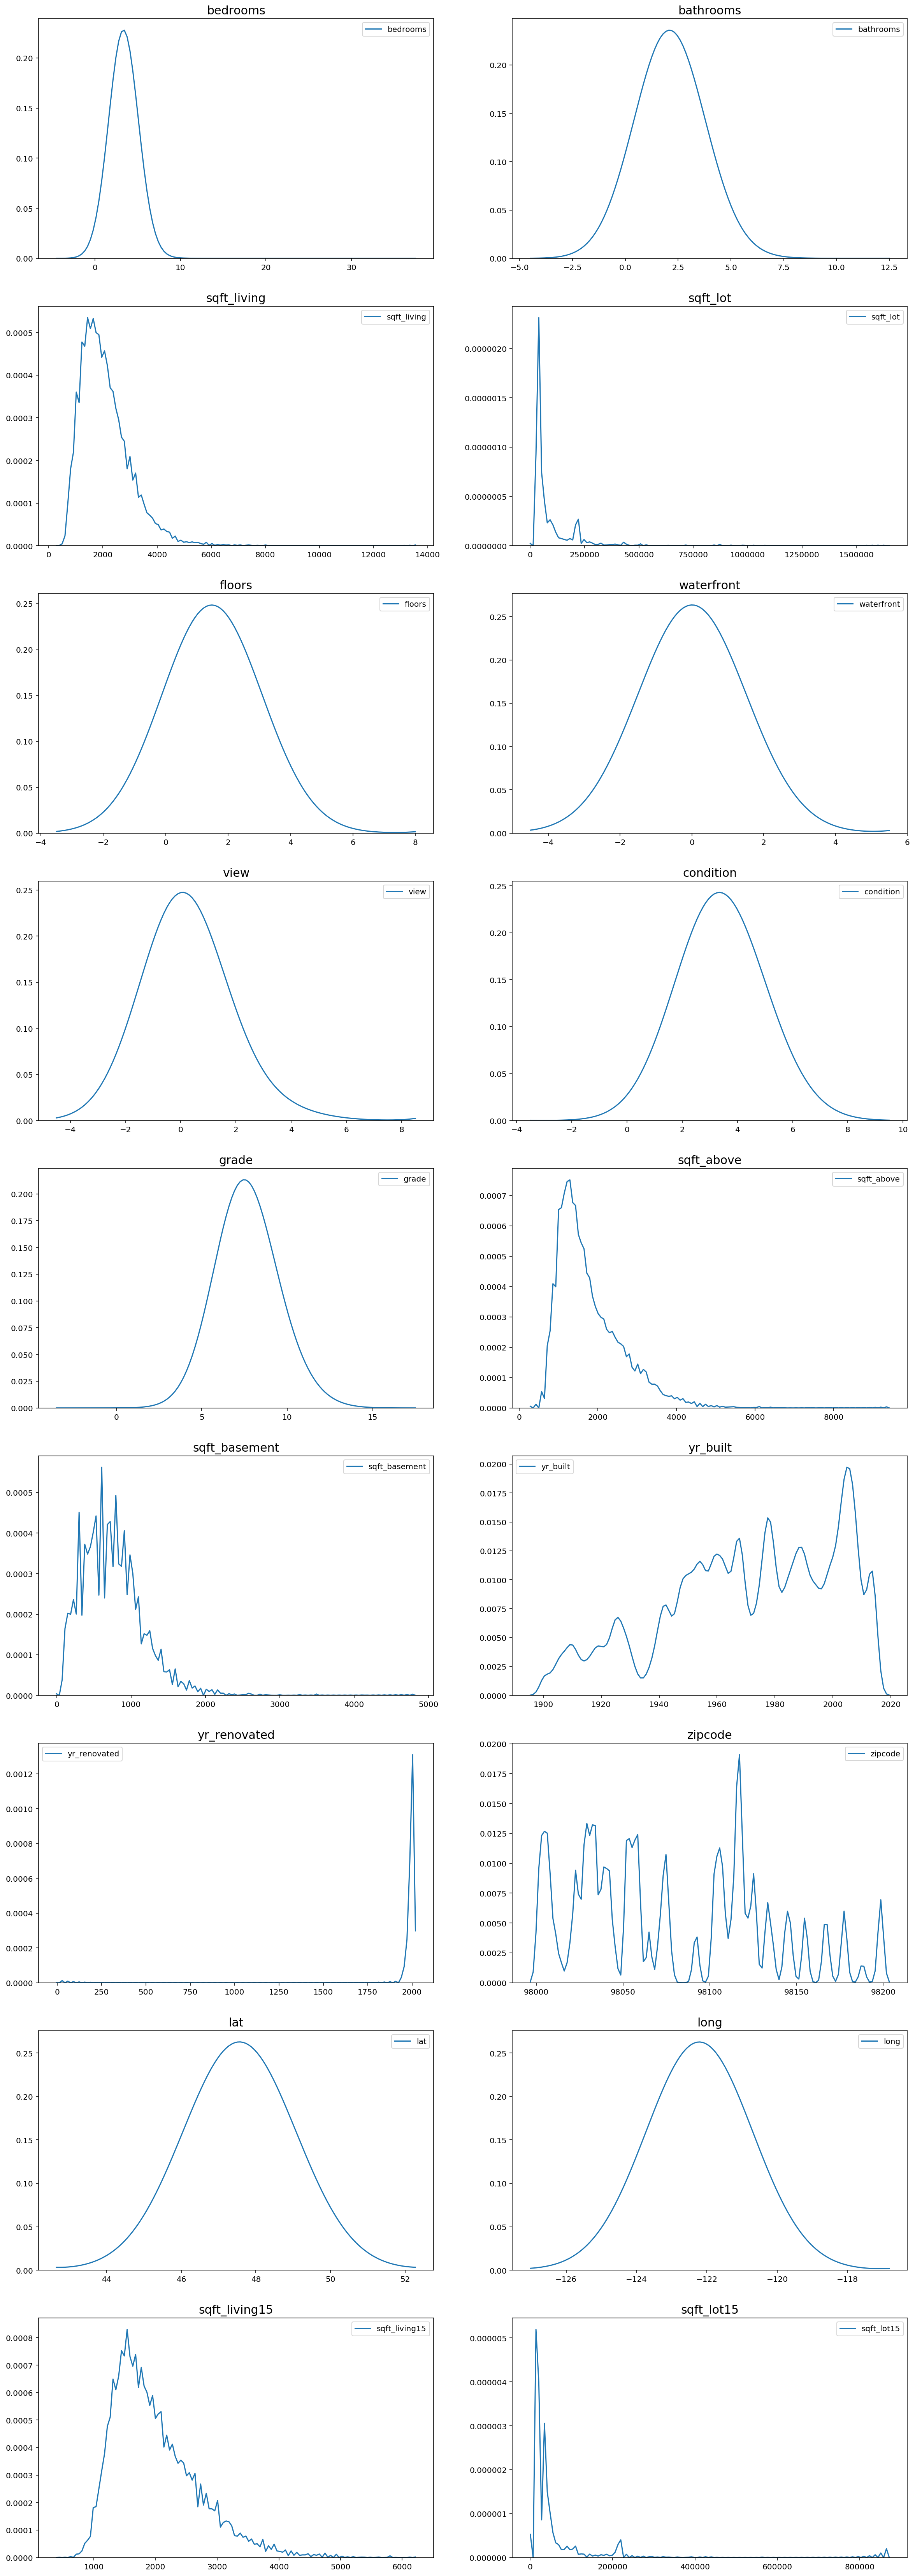

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60)) # 값, 아이디 칼럼을 지웠기에 18개 항목을 9X2 그래프로 표현
#그래프 가로 크기가 커서 스크롤바가 생기면 20에서 줄이기.
# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col], bw=1.5)
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
#numpy.log1p()는 각 입력배열의 요소를 자연로그 log(1+x)로 반환
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

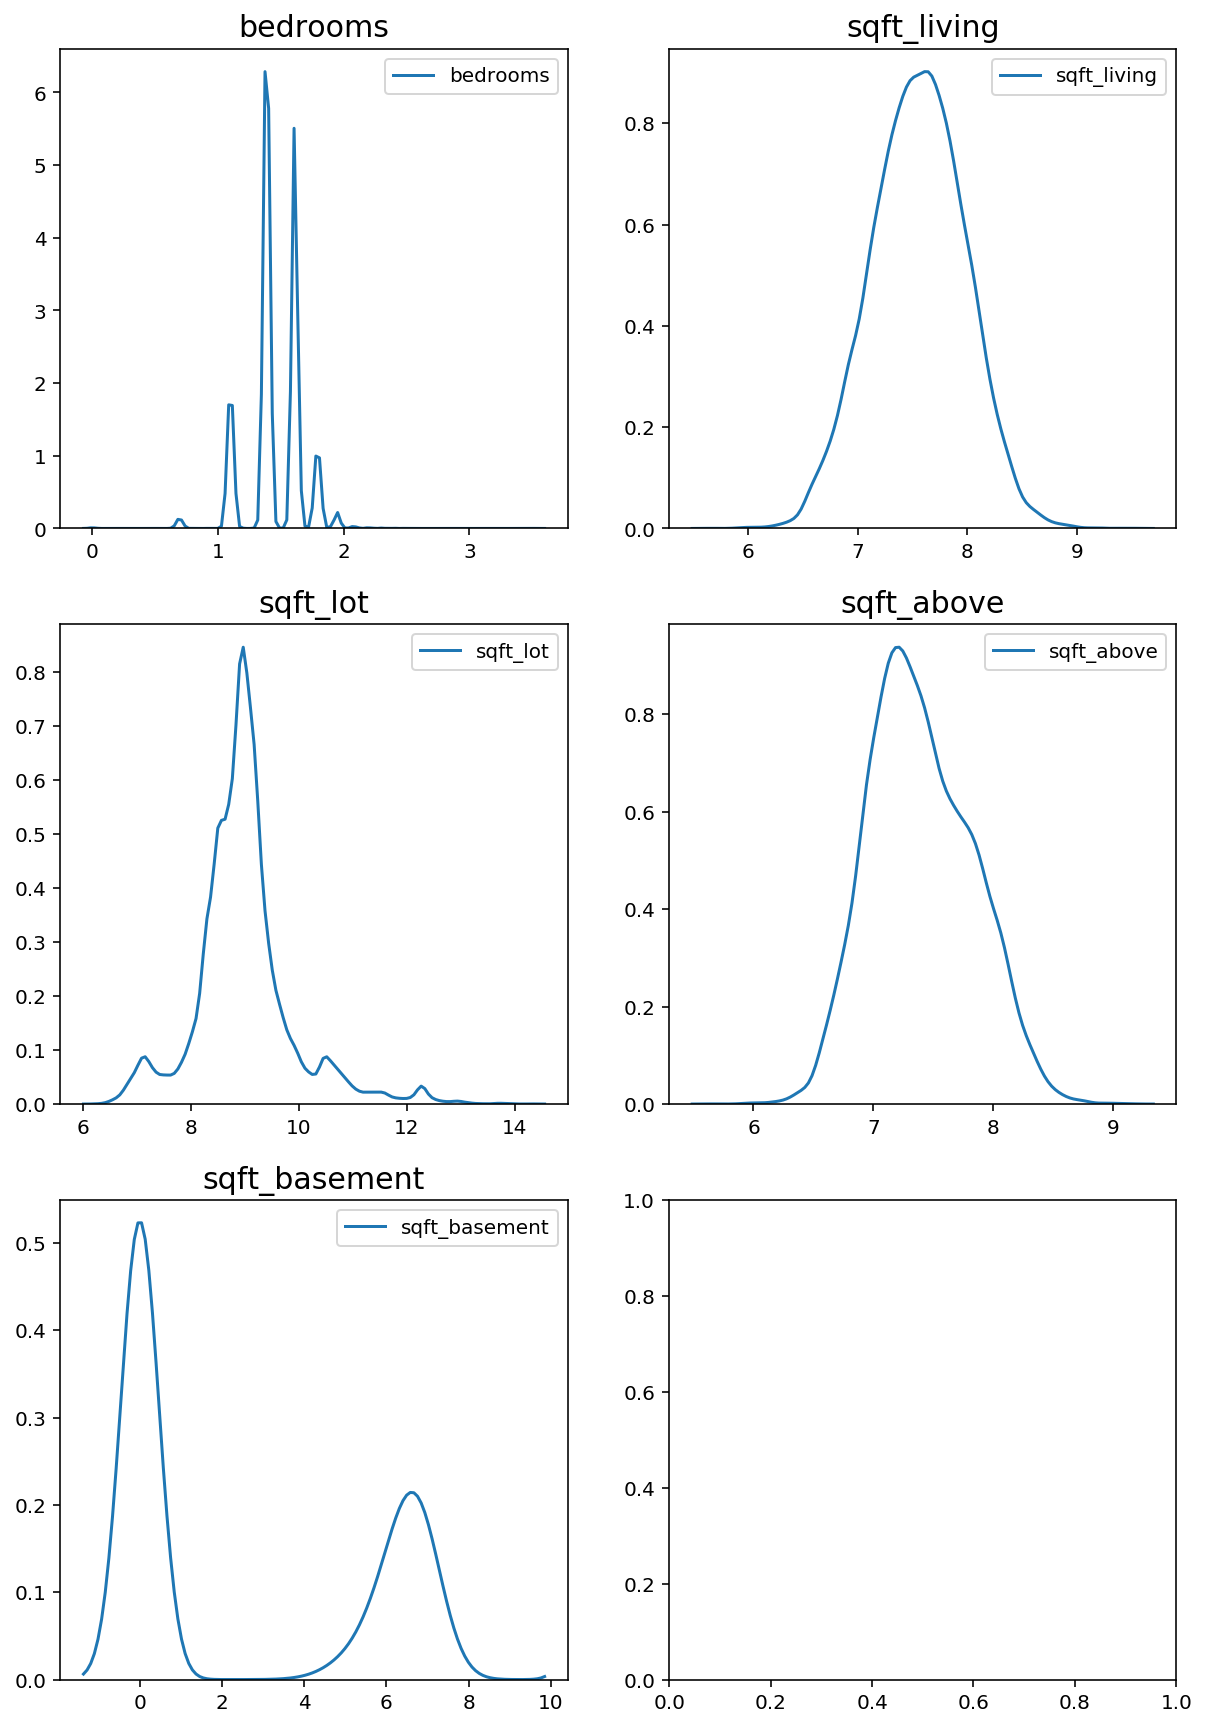

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15)) #위의 5가지를 다시 그래프로 표현

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

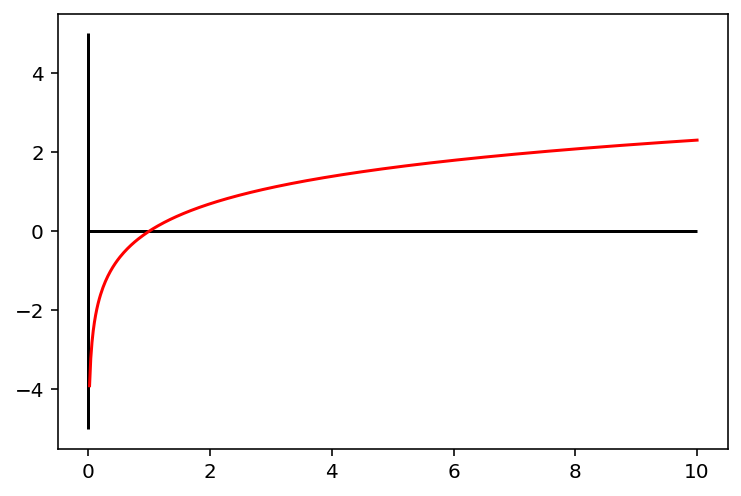

In [14]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

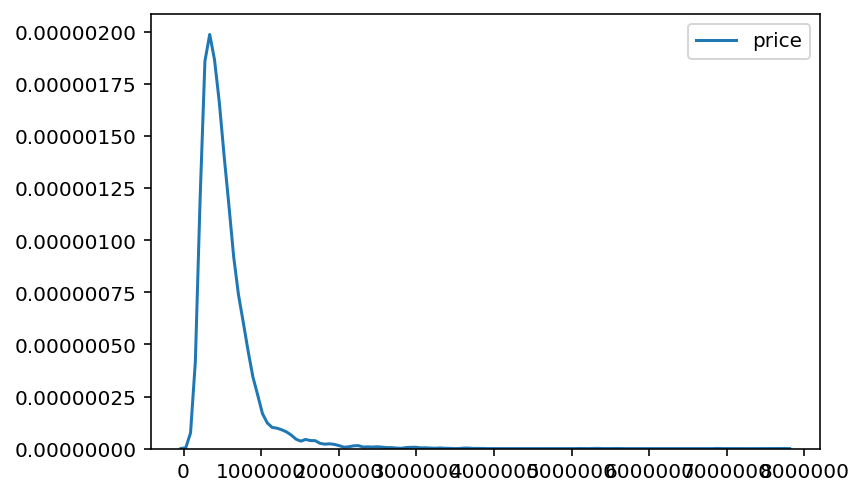

In [15]:
#price data 분포
sns.kdeplot(y)
plt.show()

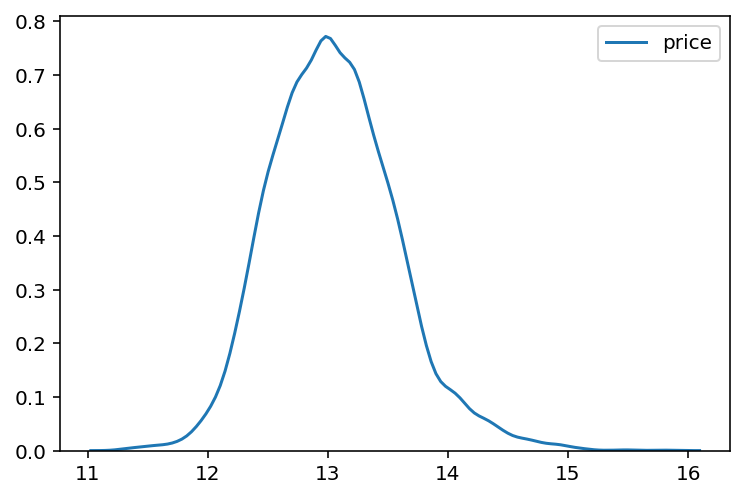

In [16]:
y_log_transformation = np.log1p(y)
#price data 로그 변환후 분포
sns.kdeplot(y_log_transformation)
plt.show()

In [17]:
sub = data.iloc[train_len:, :]# test용 데이터로 나누기
x = data.iloc[:train_len, :]#train용 데이터로 나누기.

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [18]:
gboost = GradientBoostingRegressor(random_state=2019) # 부스팅 계열 모델 불러오기.
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [19]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values) # train 데이터를 5개로 나누어 cross validation.
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [20]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending(models 딕셔너리안의 모델을 모두 x, y로 학습시킨뒤에 predictions에 예측결과값 평균값을 만든다.

In [21]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [22]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [23]:
#주어진 sample.csv 보기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [24]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [25]:
#submission 파일 저장.
my_submission_path = join(data_dir, 'submission.csv')
sub.to_csv(my_submission_path, index=False)
print(my_submission_path)


/home/ssac19/aiffel/kaggle_kakr_housing/data/submission.csv


# 제출 프로젝트 시작!

In [26]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [27]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [28]:
#위의 표에서 date의 데이터가 지저분해서 정수형 6자리로 정리!
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [29]:
#price가 타겟 데이터이므로 따로 저장하고 train데이터에서 빼기. 
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [30]:
#id도 제거
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [31]:
#test데이터에서도 동일한 작업을 실행. test데이터에는 price가 없으므로 id만 제거
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [32]:
#price 정보
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

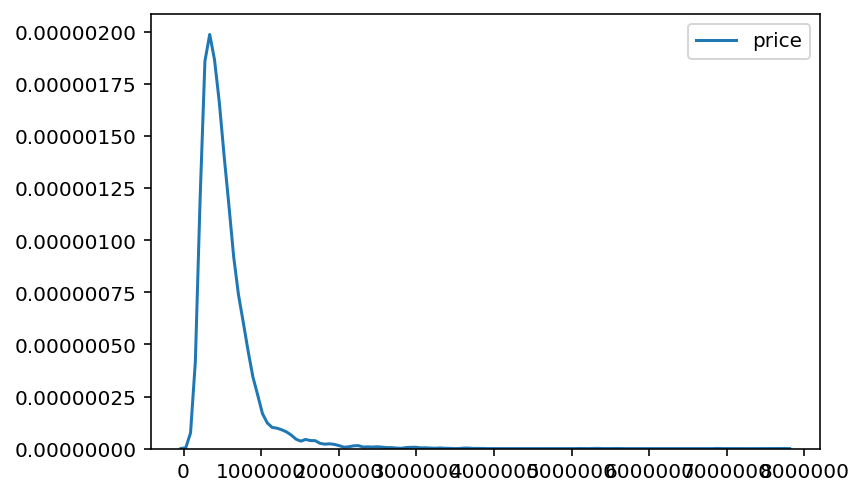

In [33]:
#가격 분포도 그래프 
sns.kdeplot(y)
plt.show()

In [34]:
#log 변환을 적용
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

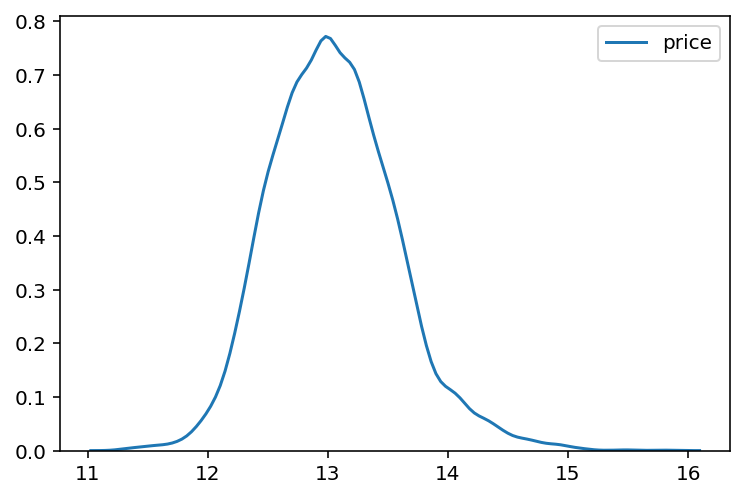

In [35]:
#log변환된 가격 분포도 그래프 
sns.kdeplot(y)
plt.show()

In [36]:
#train데이터 정보
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [37]:
#rmse결과값을 계산하기 위해서 mean_squared_error, 데이터셋->훈련셋+검증셋하기 위해서 train_test_split을 import
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [38]:
#y값을 log 변환해놨기 때문에 원래대로 복구!
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [39]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [40]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. (고정하지 않으면 다른 데이터 변화에 따른 변화가 오염될 수 있다.)

#모델 인스턴스를 만들어서 models 리스트에 넣기.
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [41]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [42]:
df = {}
#각 모델별 학습, 예측
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125576.03932336495}

In [43]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [44]:
#다양한 하이퍼 파라미터로 실험하기위해 gridsearchcv 클래스 활용.
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


In [116]:
#탐색할 파라미터 종류를 넣는다.(딕셔너리로 입력)
param_grid = {
    'n_estimators': [50, 75, 100, 150],
    'boosting_type': ['rf', 'gbdt', 'dart', 'goss'],
    'num_iterations': [100, 500, 750, 1000],
    'max_depth': [10, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [50, 100, 200]
}

In [117]:
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [119]:
#param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
#scoring : 모델의 성능을 평가할 지표
#cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
#verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
#n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=10)

grid_model.fit(train, y)


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 530 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 1530 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done 2450 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 2900 tasks      | elapsed:  5.8min
[Parallel(n_jobs=10)]: Done 3450 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 4100 tasks      | elapsed: 13.1min
[Parallel(n_jobs=10)]: Done 4850 tasks      | elapsed: 37.9min
[Parallel(n_jobs=10)]: Done 5700 tasks      | elapsed: 76.0min
[Parallel(n_jobs=10)]: Done 6650 tasks      | elapsed: 112.5min
[Parallel(n_jobs=10)]: Done 7700 tasks      | elapsed: 119.6min
[Parallel(n_jobs=10)]: Done 8640 out of 8640 | elapsed: 126.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2020,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True...
                                     subsample_freq=0),
             iid='deprecated', n_jobs=10,
             param_grid={'boosting_type': ['rf', 'gbdt', 'dart', 'goss'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [10, 50, 100],
                         'n_estimators': [50, 75, 100, 150],
         

위에서 우리가 입력한 param_grid에 n_estimators 두 가지, max_depth 두 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지입니다.     

또한, cross validation은 각 경우마다 5번을 진행하니 총 20 fits를 진행하게 됩니다.

여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다. 간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하겠죠!


In [120]:
#4가지 조합에 대한 결과값 저장
grid_model.cv_results_

{'mean_fit_time': array([0.08166556, 0.08849645, 0.04056158, ..., 4.64581704, 6.72632761,
        7.18916774]),
 'std_fit_time': array([0.01309379, 0.00985499, 0.00353854, ..., 0.57347047, 0.53552342,
        0.49171403]),
 'mean_score_time': array([0.        , 0.        , 0.        , ..., 0.49890008, 0.57057056,
        0.5116065 ]),
 'std_score_time': array([0.        , 0.        , 0.        , ..., 0.0439694 , 0.07347905,
        0.0495131 ]),
 'param_boosting_type': masked_array(data=['rf', 'rf', 'rf', ..., 'goss', 'goss', 'goss'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, ..., 0.1, 0.1, 0.1],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 10, 10, ..., 100, 100, 100],
              mask=[False, False, False, ..., False, False, False

In [121]:
#정보가 너무 많아 우리가 볼 항목만 따로 뺴기.
#파라미터 조합
params = grid_model.cv_results_['params']
params

[{'boosting_type': 'rf',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 100,
  'num_leaves': 50},
 {'boosting_type': 'rf',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 100,
  'num_leaves': 100},
 {'boosting_type': 'rf',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 100,
  'num_leaves': 200},
 {'boosting_type': 'rf',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 500,
  'num_leaves': 50},
 {'boosting_type': 'rf',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 500,
  'num_leaves': 100},
 {'boosting_type': 'rf',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 500,
  'num_leaves': 200},
 {'boosting_type': 'rf',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 750,
  'num_leaves': 50},
 {'boosting_type': 'rf',
  'learning_

In [122]:
#정보가 너무 많아 우리가 볼 항목만 따로 뺴기.
#조합에 따른 점수
score = grid_model.cv_results_['mean_test_score']
score

array([        nan,         nan,         nan, ..., -0.02964561,
       -0.03050503, -0.0306545 ])

In [123]:
results = pd.DataFrame(params)
results['score'] = score

results

,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,num_leaves,score
0,rf,0.01,10,50,100,50,NaN
1,rf,0.01,10,50,100,100,NaN
2,rf,0.01,10,50,100,200,NaN
3,rf,0.01,10,50,500,50,NaN
4,rf,0.01,10,50,500,100,NaN
...,...,...,...,...,...,...,...
1723,goss,0.10,100,150,750,100,-0.030315
1724,goss,0.10,100,150,750,200,-0.030582
1725,goss,0.10,100,150,1000,50,-0.029646
1726,goss,0.10,100,150,1000,100,-0.030505


In [124]:
#scoring이 neg였기에 -1 곱하고 루트연산
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,num_leaves,score,RMSE
0,rf,0.01,10,50,100,50,NaN,NaN
1,rf,0.01,10,50,100,100,NaN,NaN
2,rf,0.01,10,50,100,200,NaN,NaN
3,rf,0.01,10,50,500,50,NaN,NaN
4,rf,0.01,10,50,500,100,NaN,NaN
...,...,...,...,...,...,...,...,...
1723,goss,0.10,100,150,750,100,-0.030315,0.174112
1724,goss,0.10,100,150,750,200,-0.030582,0.174876
1725,goss,0.10,100,150,1000,50,-0.029646,0.172179
1726,goss,0.10,100,150,1000,100,-0.030505,0.174657


In [125]:
#원래 10만자지 RMSE와 값이 다른 이유는 price를 log변환했음에도 중간에 원상태로 되돌리는 과정을 하지 않아 log변환된 것들의 RMSE  
#즉, RMSLE를 구한것이다.
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,num_leaves,score,RMSLE
0,rf,0.01,10,50,100,50,NaN,NaN
1,rf,0.01,10,50,100,100,NaN,NaN
2,rf,0.01,10,50,100,200,NaN,NaN
3,rf,0.01,10,50,500,50,NaN,NaN
4,rf,0.01,10,50,500,100,NaN,NaN
...,...,...,...,...,...,...,...,...
1723,goss,0.10,100,150,750,100,-0.030315,0.174112
1724,goss,0.10,100,150,750,200,-0.030582,0.174876
1725,goss,0.10,100,150,1000,50,-0.029646,0.172179
1726,goss,0.10,100,150,1000,100,-0.030505,0.174657


In [126]:
#RMSLE가 낮은 순서대로 정렬
results = results.sort_values('RMSLE')
results

,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,num_leaves,score,RMSLE
1401,goss,0.01,100,50,1000,50,-0.025992,0.161221
1425,goss,0.01,100,100,1000,50,-0.025992,0.161221
1389,goss,0.01,50,150,1000,50,-0.025992,0.161221
1365,goss,0.01,50,75,1000,50,-0.025992,0.161221
1377,goss,0.01,50,100,1000,50,-0.025992,0.161221
...,...,...,...,...,...,...,...,...
427,rf,0.10,100,150,750,100,NaN,NaN
428,rf,0.10,100,150,750,200,NaN,NaN
429,rf,0.10,100,150,1000,50,NaN,NaN
430,rf,0.10,100,150,1000,100,NaN,NaN


1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.


def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
  1  grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

param_grid = {
   'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

results = results.sort_values('RMSLE')
results

In [127]:
#가장 좋은 조합이 10, 100이므로 이 파라미터로 구성된 모델 준비, 학습, 예측
model = LGBMRegressor(max_depth=100, n_estimators=50, boosting_type='goss', learning_rate=0.01, num_iterations=1000, num_leaves=50, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12765951, 13.0930435 , 14.17214333, ..., 13.04347147,
       12.66387218, 12.97361865])

In [128]:
#log변환한 값을 예측한 것이므로 원상복귀!
prediction = np.expm1(prediction)
prediction

array([ 502654.09162818,  485551.89125866, 1428510.18970572, ...,
        462068.90771028,  316117.42443372,  430893.53699792])

In [129]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [130]:
submission['price'] = prediction
submission.head()
#price 칼럼에 우리가 예측한 값 넣기

,id,price
0,15035,5.026541e+05
1,15036,4.855519e+05
2,15037,1.428510e+06
3,15038,3.001034e+05
4,15039,3.327872e+05


submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)
#파일 이름에 RMSLE값을 넣어서 저장

In [131]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [132]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161221')
#예측결과 저장

/home/ssac19/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161221.csv saved!


private: 113348.89868  
public: 110157.09210